In [1]:
import numpy as np
#from numpy import savez_compressed,savez
from numpy import load
#from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,f1_score,accuracy_score 
import glob
from osgeo import osr,gdal
#%%

In [2]:
import numpy
count=0
b = numpy.load(r'C:\Users\admin\Project\AFB_results\carto_mix_256_final.npz')
print(b['arr_0'])
for i in b['arr_0']:
    count += 1
print(count)

[[[[0.53626376 0.6593674  0.56725144]
   [0.53406596 0.68613136 0.5847953 ]
   [0.53626376 0.68126523 0.57894737]
   ...
   [0.3824176  0.3917275  0.36549708]
   [0.36043957 0.40632603 0.41520467]
   [0.35824177 0.459854   0.44152048]]

  [[0.53406596 0.6666667  0.57309943]
   [0.5516484  0.68126523 0.58187133]
   [0.54065937 0.6836983  0.57894737]
   ...
   [0.34505495 0.34793186 0.32748538]
   [0.35164836 0.3941606  0.36549708]
   [0.35824177 0.459854   0.4239766 ]]

  [[0.52747256 0.67153287 0.5643275 ]
   [0.5582418  0.68126523 0.57309943]
   [0.53626376 0.6836983  0.57894737]
   ...
   [0.35604396 0.35523114 0.32163742]
   [0.34945056 0.37226278 0.3362573 ]
   [0.35384616 0.42822385 0.4239766 ]]

  ...

  [[0.53626376 0.5815085  0.42982456]
   [0.51868135 0.5620438  0.41520467]
   [0.50989014 0.54744524 0.4093567 ]
   ...
   [0.45714286 0.50121653 0.374269  ]
   [0.46373627 0.49635038 0.39766082]
   [0.45714286 0.54257905 0.4122807 ]]

  [[0.5714286  0.59610707 0.4619883 ]
   [0.5

392


In [3]:
#train_data = load('E:/carto_1_256_final.npz') # TN images
#test_data = load('E:/carto_2_256_final.npz') # Punjab images
train_data = load('AFB_results/carto_mix_256_final.npz') # TN images
test_data = load('AFB_results/carto_mix_256_test.npz') # Punjab images
X_train, y_train = train_data['arr_0'], train_data['arr_1']
X_test, y_test = test_data['arr_0'], test_data['arr_1']
#%%

In [4]:
import tensorflow
linknet_model = tensorflow.keras.models.load_model('AFB_results/Linknetweights.27-0.82.h5',compile=False)
unet_model = tensorflow.keras.models.load_model('AFB_results/Unetweights.11-0.84.h5',compile=False)
fpn_model = tensorflow.keras.models.load_model('AFB_results/FPNweights.18-0.83.h5',compile=False)
#%%

In [5]:
linknet_prediction = linknet_model.predict(X_test)
unet_prediction = unet_model.predict(X_test)
fpn_prediction = fpn_model.predict(X_test)
#%%

In [6]:
def plot_predictions(num):
    plt.suptitle('Cartosat 2 and Predicted Boundaries ' + str(num))
    plt.subplot(1,5,1)
    plt.imshow(X_test[num])
    plt.axis('off')
    plt.title('Cartosat-2 image')

    plt.subplot(1,5,2)
    plt.imshow(np.round(linknet_prediction[num]),cmap="gray")
    plt.title('Linknet')
    plt.axis('off')
    
    plt.subplot(1,5,3)
    plt.imshow(np.round(unet_prediction[num]),cmap="gray")
    plt.title('Unet')
    plt.axis('off')
    
    plt.subplot(1,5,4)
    plt.imshow(np.round(fpn_prediction[num]),cmap="gray")
    plt.title('FPN')
    plt.axis('off')
    
    plt.subplot(1,5,5)
    plt.imshow(y_test[num],cmap="gray")
    plt.title('Actual Boundaries')
    plt.axis('off')
    plt.show()
#%%

In [7]:
def compute_metrics(y_pred, y_true,x):
    # ytrue, ypred is a flatten vector
    y_pred = np.round(y_pred[x].flatten())
    y_true = np.round(y_true[x].flatten())
    current = confusion_matrix(y_true, y_pred, labels=[0, 1])
     # compute mean iou
    intersection = np.diag(current)
    ground_truth_set = current.sum(axis=1)
    predicted_set = current.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection
    IoU = intersection / union.astype(np.float32)
    f1 = f1_score(y_true,y_pred)
    acc = accuracy_score(y_true,y_pred)
    return np.mean(IoU), f1, acc
#%%

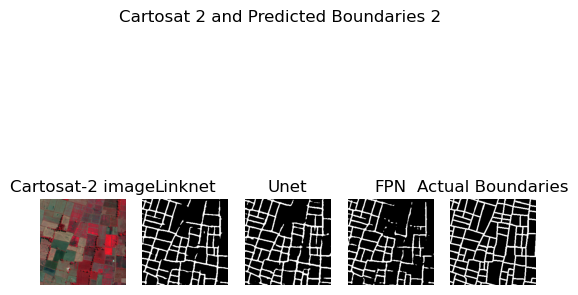

(0.6772372746133509, 0.6870136839280921, 0.85760498046875)
(0.6445632993789241, 0.6425020712510356, 0.84197998046875)
(0.6220125412540745, 0.618005678971104, 0.8255157470703125)


In [8]:
plot_predictions(2)
print(compute_metrics(linknet_prediction,y_test,9))
print(compute_metrics(unet_prediction,y_test,9))
print(compute_metrics(fpn_prediction,y_test,9))

In [9]:
#%%
def mean_metrics(prediction):
    iou = []
    f1 = []
    acc = []
    for i in range(len(X_test)):
        x,y,z = compute_metrics(prediction,y_test,i)
        iou.append(x)
        f1.append(y)
        acc.append(z)
    return np.mean(iou),np.mean(f1),np.mean(acc)

a,b,c = mean_metrics(linknet_prediction)

In [10]:
#%%
def read_image(filename):
    image = gdal.Open(filename)
    image_transform = image.GetGeoTransform()
    #image_projection = image.GetProjectionRef()
    image_array = image.ReadAsArray()
    image_array = image_array.transpose(1,2,0)
    image_array = 2*((image_array-np.min(image_array))/(np.max(image_array)-np.min(image_array)))-1
    #image_shape = image_array.shape()
    return image_transform

#final_images = [image_data[i][0] for i in range(len(image_data))]   
#%%

In [11]:
def predicted_images(input_matrix,transform,filename):
    rows,cols = 256, 256
    output_raster = gdal.GetDriverByName('GTiff').Create(filename+'.tif',cols, rows, 1 ,gdal.GDT_Float32)  # Open the file
    output_raster.SetGeoTransform(transform)
    srs = osr.SpatialReference()
    srs.ImportFromEPSG(32643)
    output_raster.SetProjection( srs.ExportToWkt() )
    output_raster.GetRasterBand(1).WriteArray(input_matrix.reshape(rows,cols))
    #output_raster = np.round(output_raster)
    #(output_raster-np.min(output_raster))/(np.max(output_raster)-np.min(output_raster))
    output_raster.FlushCache()

In [12]:
#%%
linknet_prediction = np.round(linknet_model.predict(X_test))
linknet_prediction1 = linknet_prediction[:49]
linknet_prediction2 = linknet_prediction[49:]

unet_prediction = np.round(unet_model.predict(X_test))
unet_prediction1 = unet_prediction[:49]
unet_prediction2 = unet_prediction[49:]

fpn_prediction = np.round(fpn_model.predict(X_test))
fpn_prediction1 = fpn_prediction[:49]
fpn_prediction2 = fpn_prediction[49:]

In [13]:
#%%
####Tamil Nadu
images = glob.glob(r'E:\AFB_results\scene\scene1\*.tif') 
import os
os.chdir(r'C:\Users\admin\Project\AFB_results\N_linknet1')        
image_data = [read_image(images[i]) for i in range(len(images))]
for i,j in zip(range(len(linknet_prediction1)),image_data):
    predicted_images(linknet_prediction1[i],j, 'linknet_%02d' % (i+1))

os.chdir(r'C:\Users\admin\Project\AFB_results\N_fpn1')
for i,j in zip(range(len(fpn_prediction1)),image_data):
    predicted_images(fpn_prediction1[i],j, 'fpn_%02d' % (i+1))

    os.chdir(r'C:\Users\admin\Project\AFB_results\N_unet1')    
for i,j in zip(range(len(unet_prediction1)),image_data):
    predicted_images(unet_prediction1[i],j, 'unet_%02d' % (i+1))
    
#%%

In [14]:
####Tamil Nadu
images = glob.glob(r'E:\AFB_results\scene\scene1\*.tif') 
import os
os.chdir(r'C:\Users\admin\Project\AFB_results\N_linknet2')        
image_data = [read_image(images[i]) for i in range(len(images))]
for i,j in zip(range(len(linknet_prediction2)),image_data):
    predicted_images(linknet_prediction2[i],j, 'linknet_%02d' % (i+1))

os.chdir(r'C:\Users\admin\Project\AFB_results\N_fpn2')
for i,j in zip(range(len(fpn_prediction2)),image_data):
    predicted_images(fpn_prediction2[i],j, 'fpn_%02d' % (i+1))

    os.chdir(r'C:\Users\admin\Project\AFB_results\N_unet2')    
for i,j in zip(range(len(unet_prediction2)),image_data):
    predicted_images(unet_prediction2[i],j, 'unet_%02d' % (i+1))
    
#%%

In [15]:
def read_images(filename):
    image = gdal.Open(filename)
    #image_transform = image.GetGeoTransform()
    #image_projection = image.GetProjectionRef()
    if image is None:
        raise FileNotFoundError(f"Failed to open the file: {filename}")
    image_array = image.ReadAsArray()
    #image_array = image_array.transpose(1,2,0)
    #image_array = 2*((image_array-np.min(image_array))/(np.max(image_array)-np.min(image_array)))-1
    #image_shape = image_array.shape()
    return image_array

In [16]:
#%%
def whole_metrics(y_pred, y_true):
    # ytrue, ypred is a flatten vector
    y_pred = y_pred.flatten()
    y_true = y_true.flatten()
    y_true[y_true<0] = 0
    current = confusion_matrix(y_true, y_pred, labels=[0, 1])
     # compute mean iou
    intersection = np.diag(current)
    ground_truth_set = current.sum(axis=1)
    predicted_set = current.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection
    IoU = intersection / union.astype(np.float32)
    f1 = f1_score(y_true,y_pred,average='weighted')
    acc = accuracy_score(y_true,y_pred)
    return np.nanmean(IoU), f1, acc

In [17]:
#%%
tn_bound = read_images(r'C:\Users\admin\Project\AFB_results\boundary\boundary1\boundary1.63.tif')
fpn_tn = read_images(r'C:\Users\admin\Project\AFB_results\N_unet1\fpn_36.tif')
unet_tn = read_images(r'C:\Users\admin\Project\AFB_results\N_unet1\unet_36.tif')
linknet_tn = read_images(r'C:\Users\admin\Project\AFB_results\N_linknet1\linknet_36.tif')

pjb_bound = read_images(r'C:\Users\admin\Project\AFB_results\boundary\boundary2\boundary2.64.tif')
fpn_pjb = read_images(r'C:\Users\admin\Project\AFB_results\N_unet2\fpn_36.tif')
unet_pjb = read_images(r'C:\Users\admin\Project\AFB_results\N_unet2\unet_36.tif')
linknet_pjb = read_images(r'C:\Users\admin\Project\AFB_results\N_linknet2\linknet_36.tif')

In [18]:
from tabulate import tabulate
def print_metrics_as_table(metrics, model_names):
    table = [["Model", "Mean IoU", "F1 Score", "Accuracy"]]
    for metric, model_name in zip(metrics, model_names):
        table.append([model_name, metric[0], metric[1], metric[2]])
    
    print(tabulate(table, headers="firstrow", tablefmt="grid"))

In [19]:
metrics_unet_tn = whole_metrics(unet_tn, tn_bound)
metrics_linknet_tn = whole_metrics(linknet_tn, tn_bound)
metrics_fpn_tn = whole_metrics(fpn_tn, tn_bound)
metrics_unet_pjb = whole_metrics(unet_pjb, pjb_bound)
metrics_linknet_pjb = whole_metrics(linknet_pjb, pjb_bound)
metrics_fpn_pjb = whole_metrics(fpn_pjb, pjb_bound)

In [20]:
metrics_list = [metrics_unet_tn, metrics_linknet_tn, metrics_fpn_tn,
                metrics_unet_pjb, metrics_linknet_pjb, metrics_fpn_pjb]
model_names = ["Unet TN", "Linknet TN", "FPN TN",
               "Unet PJB", "Linknet PJB", "FPN PJB"]

# Print the metrics in a tabular format
print_metrics_as_table(metrics_list, model_names)

+-------------+------------+------------+------------+
| Model       |   Mean IoU |   F1 Score |   Accuracy |
+=============+============+============+============+
| Unet TN     |   0.638076 |   0.840514 |   0.845245 |
+-------------+------------+------------+------------+
| Linknet TN  |   0.659684 |   0.853563 |   0.859436 |
+-------------+------------+------------+------------+
| FPN TN      |   0.622548 |   0.831443 |   0.836273 |
+-------------+------------+------------+------------+
| Unet PJB    |   0.75566  |   0.912357 |   0.910522 |
+-------------+------------+------------+------------+
| Linknet PJB |   0.772323 |   0.918982 |   0.91684  |
+-------------+------------+------------+------------+
| FPN PJB     |   0.764953 |   0.917178 |   0.916412 |
+-------------+------------+------------+------------+


In [21]:
import matplotlib.pyplot as plt

def plot_predictions(a, b, c, d, filename):
    plt.figure(figsize=(20, 5))  # Adjusting the figure size for better visibility
    plt.subplot(1, 4, 1)
    plt.imshow(a, cmap="gray")
    plt.title('Actual Boundaries')
    plt.subplot(1, 4, 2)
    plt.imshow(b, cmap="gray")
    plt.title('FPN Predicted Boundaries')
    plt.subplot(1, 4, 3)
    plt.imshow(c, cmap="gray")
    plt.title('Unet Predicted Boundaries')
    plt.subplot(1, 4, 4)
    plt.imshow(d, cmap="gray")
    plt.title('Linknet Predicted Boundaries')
    plt.savefig(filename, dpi=600)
    plt.close()  # Close the figure to free memory

In [22]:
# Plotting and saving the first set of predictions
plot_predictions(tn_bound, fpn_tn, unet_tn, linknet_tn, 'TN_predictions.png')

# Plotting and saving the second set of predictions
plot_predictions(pjb_bound, fpn_pjb, unet_pjb, linknet_pjb, 'PJB_predictions.png')